In [1]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from scipy import signal
from IPython.display import Audio
import wavio

In [2]:
filename = 'drums_zanark'#'136_1b1_Ar_sc_Meditron'
audio, samplerate = sf.read(f'{filename}.wav')
Audio(audio, rate=samplerate)

In [2]:
def decimation_signal(signal, step):
    return signal[::step]

def stretching_signal(signal, N_stretch):
    return np.array([signal[i//N_stretch] if i%N_s == 0 else 0
                     for i in range(len(signal) * N_stretch)])

def moving_average(signal, Lf):
    # Definición de N
    N = len(signal)
    # Creación del vector del resultado
    result = np.zeros(N)
    
    # Se hace el promedio para cada segmento
    for n in range(N):
        if 0 <= n <= Lf - 1:
            result[n] = np.divide(sum(signal[:n+Lf+1]), Lf + n + 1)
        elif Lf <= n <= N - Lf - 1:
            result[n] = np.divide(sum(signal[n-Lf:n+Lf+1]), 2*Lf + 1)
        elif N - Lf <= n <= N - 1:
            result[n] = np.divide(sum(signal[n-Lf:N]), Lf + N - 1)
            
    return result

def find_valley_point(signal_in):
    # En primer lugar, encontrar el primer punto máximo de la señal (peak)
    primary_peak = np.argmax(signal_in)
    print(primary_peak)

In [62]:
def downsampling_signal(signal_in, samplerate, method='lowpass', 
                        lp_method='scipy_iir', cutoff_freq=1000, 
                        normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir,dada una frecuencia de corte
    máxima de interés, se resampleará la señal al doble de esa
    frecuencia.
    
    Parámetros
    - signal_in: Señal a submuestrear
    - samplerate: Tasa de muestreo de la señal "signal_in"
    - method: Método de submuestreo
        - [lowpass]: Se aplica un filtro pasabajos para evitar
                     aliasing de la señal. Luego se submuestrea
        - [None]: Simplemente se corta en la frecuencia de interés 
    - lp_method: Método de filtrado (revisar lowpass_filter)
    - cutoff_freq: Frecuencia de corte máxima de interés de la señal
    - normalize: Normalización de la señal de salida
    '''
    
    # Se calcula el paso de la decimación
    N = round(samplerate / (cutoff_freq * 2))
    
    if method == 'lowpass':
        signal_lp = lowpass_filter(signal_in, samplerate, cutoff_freq,
                                   method=lp_method)
        
        # Aplicando decimación
        return decimation_signal(signal_lp, step=N)

def lowpass_filter(signal_in, samplerate, cutoff_freq, method='scipy_fir', 
                   gpass=1, gstop=80, plot_filter=False, normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuariom el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - cutoff_freq: frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - [scipy_fir]: se implementa un filtro fir mediante funciones 
                       predeterminadas de scipy
        - [scipy_iir]: se implementa un filtro iir mediante funciones 
                       predeterminadas de scipy 
        - [manual]: implementada propiamente'''
    
    if method == 'scipy_fir':
        pass
    
    elif method == 'scipy_iir':
        num, den = signal.iirdesign(wp=cutoff_freq / samplerate,
                                    ws=cutoff_freq / (samplerate / 2),
                                    gpass=gpass, gstop=gstop)
        
    # Y obteniendo la función de transferencia h
    w, h = signal.freqz(num, den)
    
    if plot_filter:
        _, ax1 = plt.subplots()
        ax1.set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax1.plot(w, magnitude, 'r')
        ax1.set_ylabel('Magnitude [dB]', color='r')
        ax1.set_xlabel('Frequencia [rad/sample]')
        ax1.set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax1.twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
        
    # Para poder filtrar el audio
    signal_filtered = signal.lfilter(num, den, signal_in)
    
    if normalize:
        return signal_filtered / max(abs(signal_filtered))
    else:
        return signal_filtered
    
    
def denoising_signal(signal_in, samplerate):
    pass


def murmur_elimination(signal_in, samplerate, Lf=5, endpoint_method='simple',plot=True):
    '''Función que permite eliminar los ruidos de "murmullo" dentro de la
    señal cardíaca. Este método se conoce como "automatic-cutoff-frequency 
    lowpass filter" (ALPF), donde la frecuencia de corte se base analizando
    la FFT de la señal.
    Basado en: Qingshu Liu, et.al. An automatic segmentation method for 
               heart sounds. 2018. Biomedical Engineering.
    
    Parámetros
    - signal_in: Señal cardíaca a procesar
    - Lf: Radio de la ventana de media móvil
    - endpoint_method: Método de corte de altas frecuencias
        - [simple]: Se cortan todas las frecuencias superiores a 200 Hz'''
    # Obteniendo en primer lugar la magnitud de la frecuencia
    abs_fft_h = np.abs(np.fft.fft(signal_in))
    pha_fft_h = np.angle(np.fft.fft(signal_in))
    
    # Se aplica la media móvil planteada
    e_fft = moving_average(abs_fft_h, Lf=Lf)
    
    # Se busca el punto de corte
    first_valley_point = find_valley_point(e_fft)
    
    if endpoint_method == 'simple':
        # Se corta en frecuencia 200 Hz (según paper)
        index_to_cut = int(len(e_fft) * 200 / samplerate)
        # Se crea la salida
        e_fft_cutted = np.concatenate((e_fft[:index_to_cut],
                                     [0] * ((len(e_fft)//2 - index_to_cut) * 2 + 1),
                                     e_fft[-index_to_cut:]))                                 
    
    if plot:
        %matplotlib notebook
        plt.subplot(2,1,1)
        plt.plot(e_fft)
        plt.subplot(2,1,2)
        plt.plot(e_fft_cutted)
        plt.show()
        
    return np.fft.ifft(e_fft_cutted * np.exp(1j*pha_fft_h))

In [6]:
200 * 20 * new_rate  / new_rate

NameError: name 'new_rate' is not defined

In [9]:
cutoff = 1000
dwns_signal = downsampling_signal(audio, samplerate)

TypeError: downsampling_signal() got an unexpected keyword argument 'N'

In [158]:
sf.write(f'{filename}_filtered_{samplerate // Ns}.wav', lp_signal, samplerate)

<IPython.core.display.Javascript object>


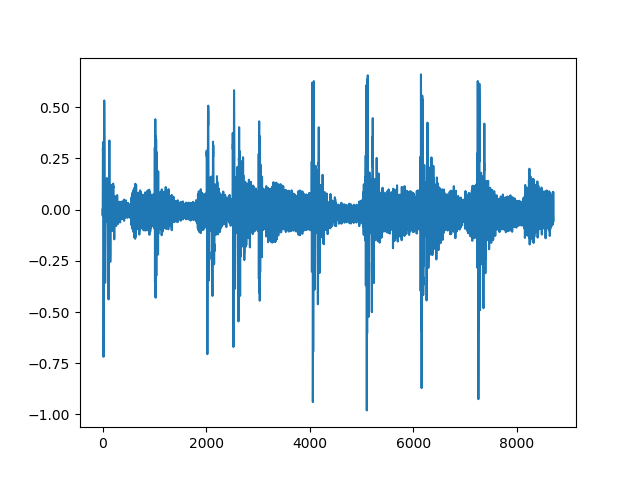

In [161]:
%matplotlib notebook
plt.plot(dwns_signal)
plt.show()

<IPython.core.display.Javascript object>


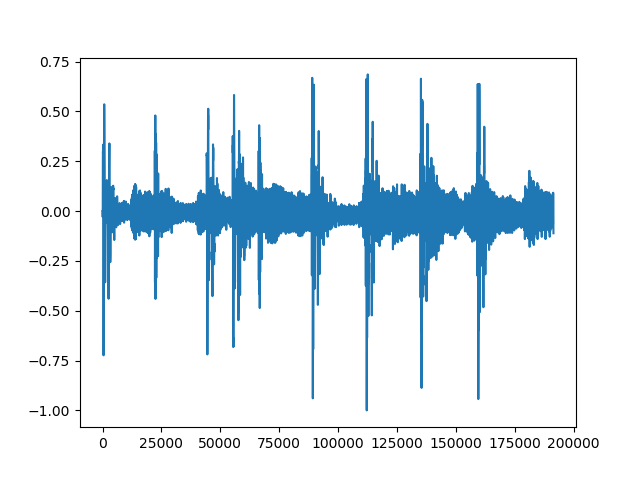

In [162]:
%matplotlib notebook
plt.plot(lp_signal)
plt.show()

In [177]:
print(samplerate/3000)
print(samplerate // 15)

14.7
2940


In [163]:
rate = samplerate//Ns             # samples per second
wavio.write(f"{filename}_down_{rate}.wav", b, rate, sampwidth=3)

# Procesando el sonido cardíaco

In [16]:
filename = '136_1b1_Ar_sc_Meditron'
audio, samplerate = sf.read(f'{filename}.wav')
Audio(audio, rate=samplerate)

## Preprocesing

In [17]:
# Disminuyendo la cantidad de muestras
cut = 1000
# Se calcula el paso de la decimación
N = round(samplerate / (cut * 2))

# Downsampleando
dwns_signal = downsampling_signal(audio, samplerate, method='lowpass', 
                                  lp_method='scipy_iir', cutoff_freq=cut, 
                                  normalize=True)

# Grabando la señal
new_rate = samplerate // N
print(new_rate)
wavio.write(f"{filename}_down_{new_rate}.wav", dwns_signal, new_rate, sampwidth=3)

2004


### Comparación con sonido solo filtrado

In [25]:
%matplotlib notebook
lp_signal =lowpass_filter(audio, samplerate, 1000, method='scipy_iir', 
               gpass=1, gstop=80, plot_filter=False)
sf.write(f'{filename}_filtered_{cut}.wav', lp_signal, samplerate)

<IPython.core.display.Javascript object>


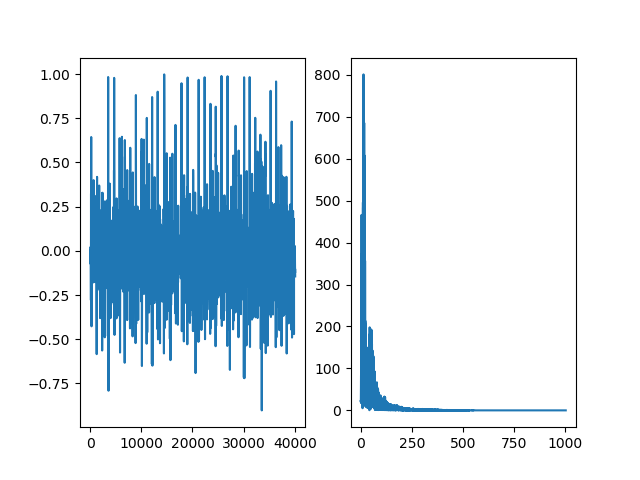

In [21]:
%matplotlib notebook
plt.subplot(1,2,1)
plt.plot(dwns_signal)
plt.subplot(1,2,2)
plt.plot(np.linspace(0, new_rate//2, len(dwns_signal) // 2 + 1), abs(np.fft.fft(dwns_signal))[:len(dwns_signal)//2+1])
plt.show()

<IPython.core.display.Javascript object>


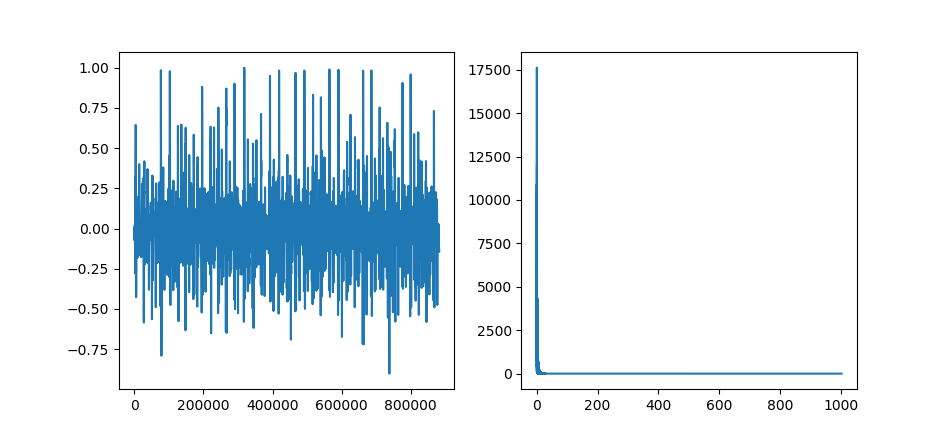

In [29]:
%matplotlib notebook
plt.subplot(1,2,1)
plt.plot(lp_signal)
plt.subplot(1,2,2)
plt.plot(np.linspace(0, new_rate//2, len(lp_signal) // 2 + 1), abs(np.fft.fft(lp_signal))[:len(lp_signal)//2+1])
plt.show()

<IPython.core.display.Javascript object>


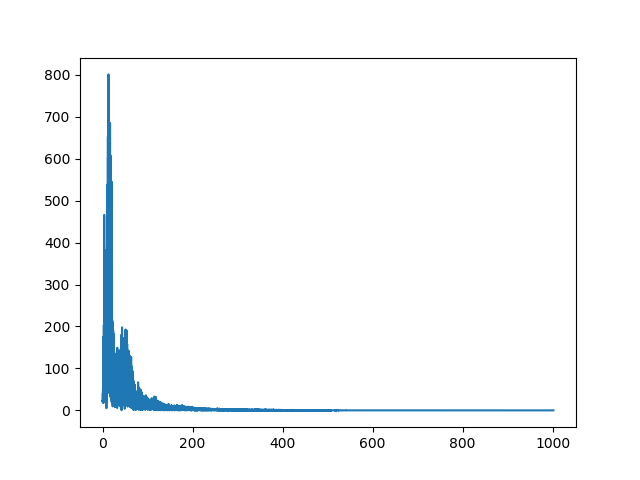

In [27]:
%matplotlib notebook
plt.plot(np.linspace(0, new_rate//2, len(dwns_signal) // 2 + 1), abs(np.fft.fft(dwns_signal))[:len(dwns_signal)//2+1])
plt.show()

## Murmur elimination

331


<IPython.core.display.Javascript object>


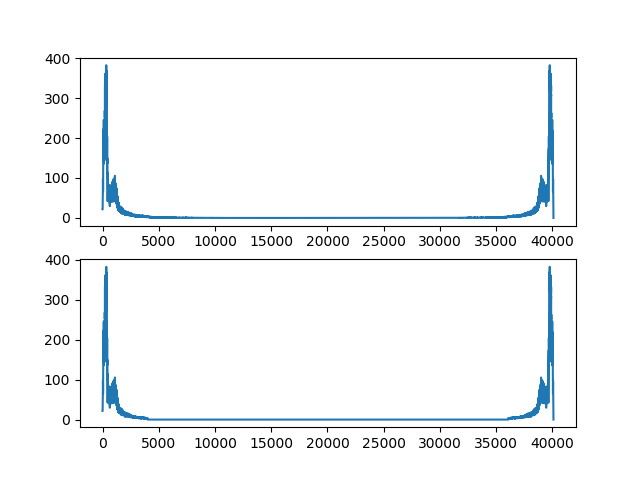

In [63]:
hs_nlp = murmur_elimination(dwns_signal, samplerate=new_rate)
wavio.write(f"{filename}_down_{new_rate}_murmur_eliminated.wav", hs_nlp, new_rate, sampwidth=3)

In [45]:
A = np.array([1,2,3,4,5,6])
print(A[-4:])

[3 4 5 6]
